# Time dependent boundary condition

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, Piecewise, sin, Matrix
import sympy

from library.python.fvm.solver_jax import HyperbolicSolver
from library.python.fvm.ode import RK1
import library.python.fvm.reconstruction as recon
import library.python.fvm.timestepping as timestepping
import library.python.fvm.flux as flux
import library.python.fvm.nonconservative_flux as nc_flux
from library.model.basemodel import eigenvalue_dict_to_matrix
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted, Legendre_DN, Chebyshevu
from library.model.models.basismatrices import Basismatrices
from library.model.models.shallow_moments import ShallowMoments
from library.model.models.shallow_moments_topo import ShallowMomentsTopoNumerical,ShallowMomentsTopo
import library.python.misc.io as io

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.python.misc.io as io
from library.python.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper

from library.python.misc.misc import Zstruct, Settings


import library.python.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.python.mesh.mesh import convert_mesh_to_jax
import argparse
from library.model.models.basisfunctions import Legendre_shifted, Basisfunction
from library.model.models.basismatrices import Basismatrices

import matplotlib.pyplot as plt


## Model

In [2]:
level = 2
settings = Settings(
    name="test",
    output=Zstruct(
        directory=f"outputs/junction_{level}", filename="test", snapshots=100, clean_directory=True
    ),
)


In [3]:
# z = sympy.Symbol("z")
# Z = np.linspace(0,1,10)
# testbasis.weight(z).subs(z, z)

In [4]:
basis = Legendre_shifted
testbasis = basis(level)
basismatrices = Basismatrices(testbasis)
U = lambda z: 1-(1-z)**8
# U = lambda z: 1. + 2*z * np.ones_like(z)
Z = np.linspace(0, 1, 100)
inflow_profile_coefs = testbasis.project_onto_basis(U(Z))
coefs = np.array(inflow_profile_coefs, dtype=np.float64)
sum = np.sum(coefs[1:])
# coefs[0] = 1
# coefs[1:] = coefs[1:] / sum
print(coefs)
print(np.sum([coefs[k] * testbasis.eval(k, testbasis.bounds()[0]) for k in range(level+1)]))



[ 0.88882087 -0.0889739  -0.05658264]
0.743264330925504


[ 0.88882087 -0.0889739  -0.05658264]
0.44246633237097016
0.44412466583916105


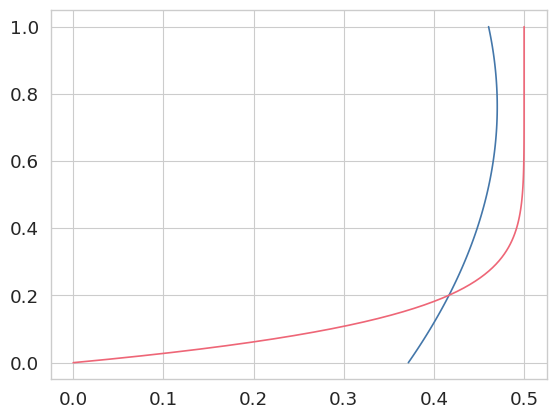

In [5]:
U_b = testbasis.reconstruct_velocity_profile(0.5*coefs, N = Z.shape[0])
U_a = 0.5 * U(Z)

plt.plot(U_b, Z)
plt.plot(U_a, Z)
print(coefs)
print(U_a.mean())
print(U_b.mean())
inflow_profile_coefs = coefs

In [6]:

f_h = lambda t: 0.2 * cos(2 * 3.14 * t/2) + 1.
u_mean = 0.5

inflow_dict = {
    0: lambda t, x, dx, q, qaux, p, n: 0.0,
    1: lambda t, x, dx, q, qaux, p, n: f_h(t),
    # 1: lambda t, x, dx, q, qaux, p, n: q[1],
    # 2: lambda t, x, dx, q, qaux, p, n: f_h(t) * u_mean * inflow_profile_coefs[0]
    # 2: lambda t, x, dx, q, qaux, p, n: q[1] * u_mean * inflow_profile_coefs[0]
    # 2: lambda t, x, dx, q, qaux, p, n: sympy.sqrt(f_h(t) * 9.81) * f_h(t),
    2: lambda t, x, dx, q, qaux, p, n: sympy.sqrt(f_h(t) * 9.81) * q[1],
    # 2: lambda t, x, dx, q, qaux, p, n: q[2]
}
# inflow_dict.update({2 + i: lambda t, x, dx, q, qaux, p, n: f_h(t) * u_mean * inflow_profile_coefs[2+i] for i in range(level)})
# inflow_dict.update({2 + i: lambda t, x, dx, q, qaux, p, n: q[0] * u_mean * inflow_profile_coefs[2+i] for i in range(level)})
# inflow_dict.update({2 + i: lambda t, x, dx, q, qaux, p, n: q[2+i] for i in range(level)})
inflow_dict.update({2 + i: lambda t, x, dx, q, qaux, p, n:  0.0 for i in range(level)})


outflow_dict = {
    1: lambda t, x, dx, q, qaux, p, n: f_h(t),
    # 2: lambda t, x, dx, q, qaux, p, n: f_h(t) * u_mean * inflow_profile_coefs[0]
    2: lambda t, x, dx, q, qaux, p, n: q[2]
}
outflow_dict.update({2 + i: lambda t, x, dx, q, qaux, p, n: q[i+2] for i in range(level)})

bcs = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag="left", prescribe_fields=inflow_dict),
        # BC.Lambda(physical_tag="right", prescribe_fields=outflow_dict),
        BC.Extrapolation(physical_tag="right"),
    ]
)


def custom_ic(x):
    Q = np.zeros(3 + level, dtype=float)
    Q[0] = 0.05 * x[0]
    Q[1] = 1.
    # Q[2] = 1.0 * np.sqrt(9.81)
    return Q


ic = IC.UserFunction(custom_ic)

class MyModel(ShallowMomentsTopo):   
    def source(self):   
        out = Matrix([0 for i in range(self.n_variables)])
        # out += self.chezy()
        # out += self.slip()
        out += self.slip_mod()
        # out += self.gravity()
        # out += self.newtonian_turbulent_algebraic()
        # out += self.regress_against_power_profile()
        return out
        # M = self.mass_matrix()
        # Minv = M.inv()
        # return Minv @ out
    # def mass_matrix(self):
    #     m = self.basismatrices.M
    #     M = sympy.zeros(self.n_variables, self.n_variables)
    #     M[0,0] = 1
    #     M[1:, 1:] = m
    #     return M
    # def eigenvalues(self):
    #     offset = self.level + 1
    #     A = super().quasilinear_matrix()[0]
    #     alpha_erase = self.variables[2 : 2 + self.level]
    #     for alpha_i in alpha_erase:
    #         A = A.subs(alpha_i, 0)
    #     M = self.mass_matrix()
    #     L = sympy.Symbol("L")
    #     ev = sympy.solve(sympy.det(A - L * M), L)
    #     return sympy.Matrix(ev)
    # def quasilinear_matrix(self):
    #     [A] = super().quasilinear_matrix()
    #     M = self.mass_matrix()
    #     Minv = M.inv()
    #     return [Minv @ A]
        
model = MyModel(
    dimension=1,
    level = level,
    boundary_conditions=bcs,
    aux_variables = 3 + level,
    parameters=Zstruct(C=30., lamda=0.001, rho=1000., kappa=0.41, l_bl=0.01, l_turb=0.05, nu=1e-6, c_slipmod=1., r_pp=10.),
    basisfunctions=basis,
    initial_conditions=ic
)

main_dir = os.getenv("ZOOMY_DIR")
# mesh = petscMesh.Mesh.from_gmsh(
#     os.path.join(main_dir, "meshes/channel_junction/mesh_2d_coarse.msh")
#     # os.path.join(main_dir, "meshes/channel_junction/mesh_2d_fine.msh")
# )

mesh = petscMesh.Mesh.create_1d([0.0, 10.0], 400)





In [7]:
class SMESolver(HyperbolicSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        Qaux = Qaux.at[0].set(compute_derivatives(Q[0], mesh, derivatives_multi_index=[[1, 0]])[:, 0])
        Qaux = Qaux.at[1].set(compute_derivatives(Q[1], mesh, derivatives_multi_index=[[1, 0]])[:, 0])

        for i in range(2, Q.shape[0]):
            Qaux = Qaux.at[i].set(compute_derivatives(Q[i]/Q[1], mesh, derivatives_multi_index=[[1, 0]])[:, 0])
        return Qaux


solver = SMESolver(settings=settings, time_end=30.0, compute_dt=timestepping.adaptive(CFL=0.9))

## Solver

In [8]:
Qnew, Qaux = solver.solve(mesh, model)

2025-09-24 12:15:21.254 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 10, time: 0.064186, dt: 0.006288, next write at time: 0.303030
2025-09-24 12:15:21.261 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 20, time: 0.127076, dt: 0.006290, next write at time: 0.303030
2025-09-24 12:15:21.268 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 30, time: 0.189985, dt: 0.006292, next write at time: 0.303030
2025-09-24 12:15:21.277 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 40, time: 0.252909, dt: 0.006293, next write at time: 0.303030
2025-09-24 12:15:21.288 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 50, time: 0.315849, dt: 0.006295, next write at time: 0.606061
2025-09-24 12:15:21.296 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 60, time: 0.378804, dt: 0.006296, next writ

## Visualization

In [9]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.name}.h5"))
postprocessing.vtk_project_2d_to_3d(model, settings, Nz=50, filename='out_3d')

2025-09-24 12:15:25.947 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 0/100
2025-09-24 12:15:25.959 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 1/100
2025-09-24 12:15:25.973 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 2/100
2025-09-24 12:15:25.989 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 3/100
2025-09-24 12:15:26.000 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 4/100
2025-09-24 12:15:26.022 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 5/100
2025-09-24 12:15:26.038 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapshot 6/100
2025-09-24 12:15:26.053 | INFO     | library.postprocessing.postprocessing:vtk_project_2d_to_3d:62 - Converted snapsho